✅ Epoch 1 completed — Val Accuracy: 0.8238
✅ Epoch 2 completed — Val Accuracy: 0.8063
✅ Epoch 3 completed — Val Accuracy: 0.8417
✅ Epoch 4 completed — Val Accuracy: 0.8452
✅ Epoch 5 completed — Val Accuracy: 0.8163
✅ Epoch 6 completed — Val Accuracy: 0.8462
✅ Epoch 7 completed — Val Accuracy: 0.8462
✅ Epoch 8 completed — Val Accuracy: 0.8557
✅ Epoch 9 completed — Val Accuracy: 0.8397
✅ Epoch 10 completed — Val Accuracy: 0.8652
✅ Epoch 11 completed — Val Accuracy: 0.8337
✅ Epoch 12 completed — Val Accuracy: 0.8238
✅ Epoch 13 completed — Val Accuracy: 0.8542
✅ Epoch 14 completed — Val Accuracy: 0.8532
✅ Epoch 15 completed — Val Accuracy: 0.8507
✅ Epoch 16 completed — Val Accuracy: 0.8497
✅ Epoch 17 completed — Val Accuracy: 0.8512
✅ Epoch 18 completed — Val Accuracy: 0.8537
✅ Epoch 19 completed — Val Accuracy: 0.8607
✅ Epoch 20 completed — Val Accuracy: 0.8347
✅ Epoch 21 completed — Val Accuracy: 0.8512
✅ Epoch 22 completed — Val Accuracy: 0.8522
✅ Epoch 23 completed — Val Accuracy: 0.84

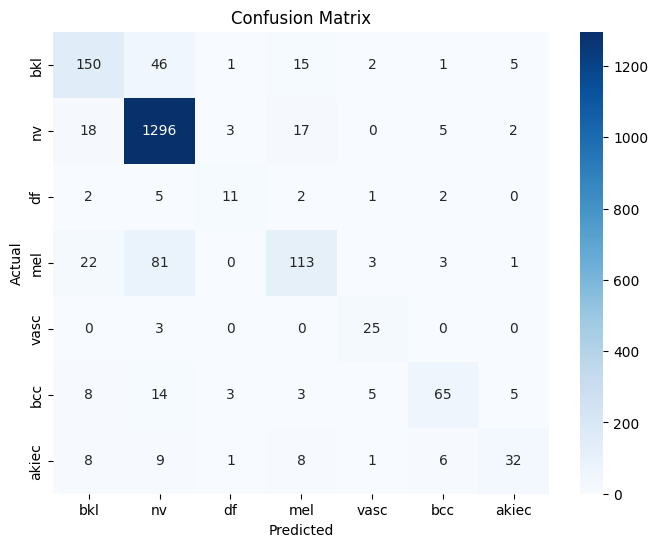

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# === Load metadata và đường dẫn ảnh ===
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
image_dir1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
image_dir2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

metadata['path'] = metadata['image_id'].map(lambda x: os.path.join(image_dir1, x + ".jpg"))
metadata['exists'] = metadata['path'].map(os.path.exists)
metadata.loc[~metadata['exists'], 'path'] = metadata['image_id'].map(lambda x: os.path.join(image_dir2, x + ".jpg"))

# === Encode label ===
label_map = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label_map)
target_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]

# === Chia train/val ===
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)

# === Dataset ===
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_loader = DataLoader(SkinDataset(train_df, transform), batch_size=32, shuffle=True)
val_loader = DataLoader(SkinDataset(val_df, transform), batch_size=32)

# === Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = torch.nn.Linear(model.fc.in_features, len(label_map))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Train ===
for epoch in range(30):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

    # Validation accuracy mỗi epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"✅ Epoch {epoch+1} completed — Val Accuracy: {acc:.4f}")

# === Đánh giá ===
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# === Classification Report ===
print(classification_report(all_labels, all_preds, target_names=target_names))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [4]:
torch.save(model.state_dict(), "skin_resnet18.pth")

In [5]:
from IPython.display import FileLink
FileLink("skin_resnet18.pth")


/kaggle/working/skin_resnet18.pth